https://michael-fuchs-python.netlify.app/2020/10/29/time-series-analysis-regression-extension-techniques-for-forecasting-multivariate-variables/

https://keras.io/examples/timeseries/timeseries_weather_forecasting/

In [1]:
# utilities
import pandas as pd 
import numpy as np
import datetime
import random
from datetime import datetime as dt
from pandas import DataFrame
import warnings
warnings.filterwarnings('ignore')

# plots
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns

# autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#model
from statsmodels.tsa.stattools import grangercausalitytests #for causality check
from statsmodels.tsa.stattools import adfuller #for stationarity check
from statsmodels.stats.stattools import durbin_watson #for autocorrelation check
#from statsmodels.tsa.seasonal import seasonal_decompose #for the decomposition
import statsmodels.api as sm
from math import sqrt
from sklearn import metrics
from sklearn.metrics import mean_squared_error
# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR

Importing datasets

In [7]:
co2 = pd.read_csv('co2.csv')

no_raindays = pd.read_csv('rainfall-monthly-number-of-rain-days.csv')
no_raindays.rename(columns={'month':'Date'},inplace=True)

sea_level = pd.read_csv('sea_level.csv')
#sea_level.rename(columns = {'Time':'Date'},inplace=True)

humidity = pd.read_csv('relative-humidity-monthly-mean.csv')
humidity.rename(columns = {'month':'Date'},inplace=True)

rainfall = pd.read_csv('rainfall-monthly-total.csv')
rainfall.rename(columns = {'month':'Date'},inplace=True)

temperature = pd.read_csv('surface-air-temperature-monthly-mean.csv')
temperature.rename(columns = {'month':'Date'},inplace=True)

anomaly_temperature = pd.read_csv('anomalies_temperature.csv')

Append new data to: co2, sea_level,anomaly_temperature in order to have data until the 2021.

First thing is to create a new list of dates then create the values of the measurement according to the values in the dataframe.

Change datatype of the column with the date into the datetime format 'YYYY-mm'

In [8]:
co2['Date'] = pd.to_datetime(co2['Date'], format = '%Y-%m')
co2['Date'] = co2['Date'].dt.strftime('%Y-%m')

sea_level['Date'] = pd.to_datetime(sea_level['Date'], format = '%Y-%m')
sea_level['Date'] = sea_level['Date'].dt.strftime('%Y-%m')

humidity['Date'] = pd.to_datetime(humidity['Date'], format = '%Y-%m')
humidity['Date'] = humidity['Date'].dt.strftime('%Y-%m')

rainfall['Date'] = pd.to_datetime(humidity['Date'], format = '%Y-%m')
rainfall['Date'] = rainfall['Date'].dt.strftime('%Y-%m')

temperature['Date'] = pd.to_datetime(temperature['Date'], format = '%Y-%m')
temperature['Date'] = temperature['Date'].dt.strftime('%Y-%m')

anomaly_temperature['Date'] = pd.to_datetime(anomaly_temperature['Date'], format = '%Y-%m')
anomaly_temperature['Date'] = anomaly_temperature['Date'].dt.strftime('%Y-%m')

Now that the dataframes are modified and the cols have the same name and format, i can merge them on the Date and build a unique dataframe.

In [9]:
climate_change = no_raindays.merge(rainfall,on='Date').merge(humidity,on='Date').merge(temperature,on='Date').merge(co2,on='Date').merge(sea_level,on='Date').merge(anomaly_temperature,on='Date')
climate_change.tail()

,Date,no_of_rainy_days,total_rainfall,relative_humidity,surface_temp,co2,GMSL(Global Mean Sea Level),Anomalies_Land_Ocean_Temperature
473,2021-06,20,93.4,77.8,28.5,429.71,12.30,1.52
474,2021-07,12,195.8,76.5,28.6,407.69,12.50,1.98
475,2021-08,24,293.6,80.4,27.6,402.19,11.61,1.70
476,2021-09,14,205.4,77.3,28.3,402.16,14.71,2.28
477,2021-10,14,177.0,78.3,28.5,411.28,9.62,1.90


In [10]:
# change the column values from percentage to decimal 
climate_change['relative_humidity'] = climate_change['relative_humidity'].apply(lambda x: x / 100)
#save the dataframe to csv
climate_change.to_csv('climate_change.csv',index=False)

In [11]:
climate_change = pd.read_csv('climate_change.csv')

In [12]:
#check there are no missing values
climate_change.isna().sum()

Date                                0
no_of_rainy_days                    0
total_rainfall                      0
relative_humidity                   0
surface_temp                        0
co2                                 0
GMSL(Global Mean Sea Level)         0
Anomalies_Land_Ocean_Temperature    0
dtype: int64

In [13]:
climate_change.tail()

,Date,no_of_rainy_days,total_rainfall,relative_humidity,surface_temp,co2,GMSL(Global Mean Sea Level),Anomalies_Land_Ocean_Temperature
473,2021-06,20,93.4,0.778,28.5,429.71,12.30,1.52
474,2021-07,12,195.8,0.765,28.6,407.69,12.50,1.98
475,2021-08,24,293.6,0.804,27.6,402.19,11.61,1.70
476,2021-09,14,205.4,0.773,28.3,402.16,14.71,2.28
477,2021-10,14,177.0,0.783,28.5,411.28,9.62,1.90


### EDA & DATA VISUALIZATION

In [14]:
def correlation(data : pd.core.frame.DataFrame):
    corr_matrix = data.corr()
    mask = np.zeros_like(corr_matrix) #to plot only a half matrix
    mask[np.triu_indices_from(mask)] = True #to generate a mask for the upper triangle
    sns.heatmap(corr_matrix, mask=mask, square=True,cmap="PuOr_r")
    return

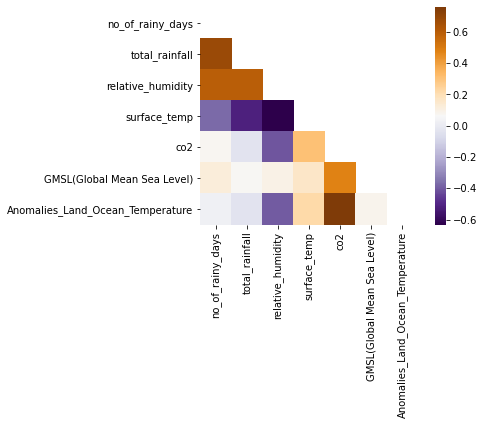

In [15]:
correlation(climate_change)

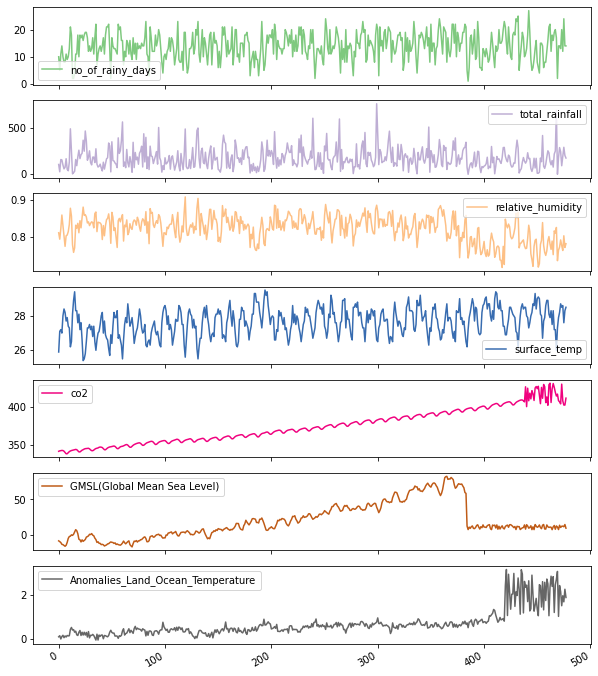

In [16]:
df = climate_change.drop('Date',axis=1)
df.plot(subplots=True, figsize=(10,13),colormap='Accent');

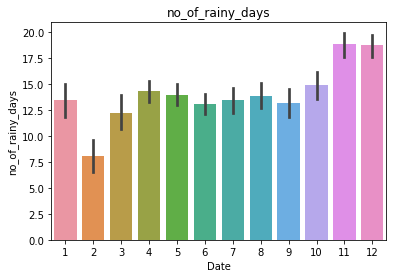

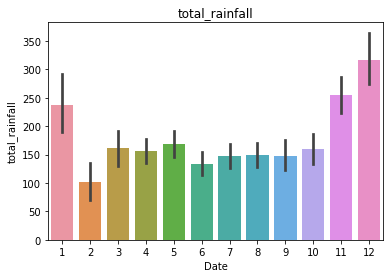

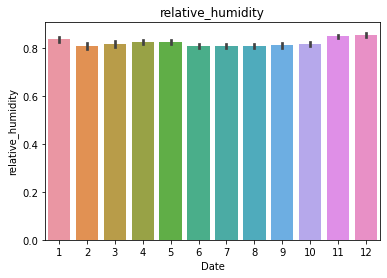

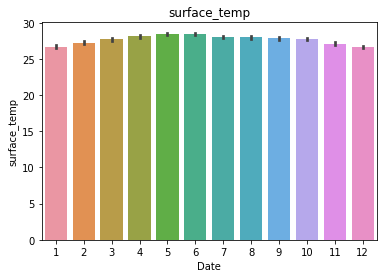

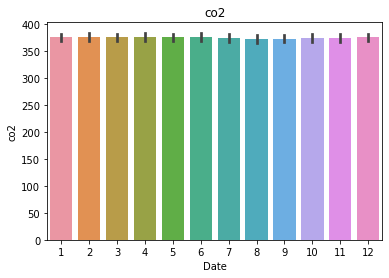

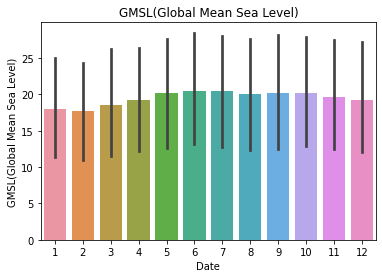

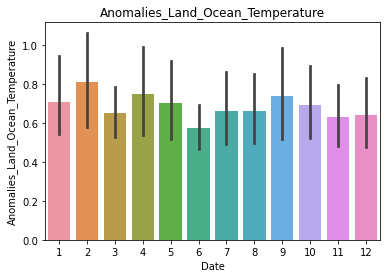

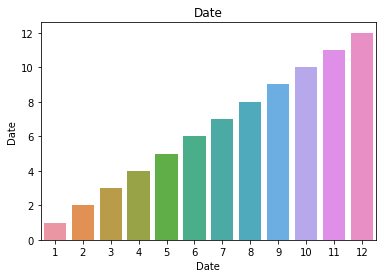

In [17]:
# only storing month for each index 
mon = climate_change['Date']
temp = pd.DatetimeIndex(mon)
# assign month part of that data to 'month' variable
month = pd.Series(temp.month)
# dropping month from to_plot_monthly_variation
to_plot_monthly_variation = climate_change
to_plot_monthly_variation = to_plot_monthly_variation.drop(['Date'], axis = 1)
# join months so we can get month to average monthly rider mapping
to_plot_monthly_variation = to_plot_monthly_variation.join(month)

# Plotting bar plot for each month
for c in to_plot_monthly_variation.columns:
    sns.barplot(x = 'Date', y = c, data = to_plot_monthly_variation)
    plt.title(f'{c}')
    plt.show()

Time series **autocorrelation**:

Autocorrelation is a mathematical representation of the degree of similarity between a given time series and a lagged version of itself over successive time intervals. It's conceptually similar to the correlation between two different time series, but autocorrelation uses the same time series twice: once in its original form and once lagged one or more time periods. It measures the relationship between a variable’s current value and its past values.

A value close to zero suggests a weak autocorrelation, whereas a value closer to -1 or 1 indicates a strong autocorrelation. An autocorrelation of +1 represents a perfect positive correlation; on the other hand, an autocorrelation of -1 represents a perfect negative correlation (an increase seen in one time series results in a proportionate decrease in the other time series).

Correlation values, called correlation coefficients, can be calculated for each observation and different lag values. Once calculated, a plot can be created to help better understand how this relationship changes over the lag.

In the surface temperature plot we can see a strong sing of seasonality given by the 'waves', but only for this variable, hence i will not split the data into seasonal data. 

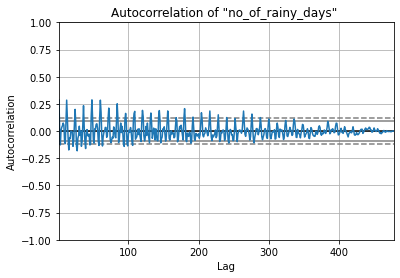

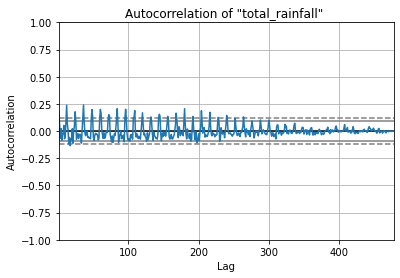

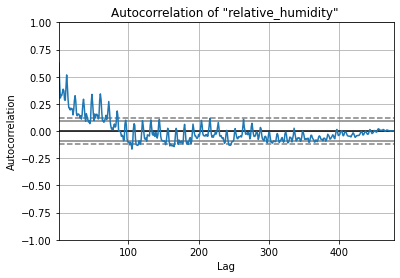

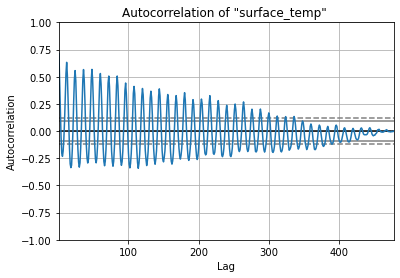

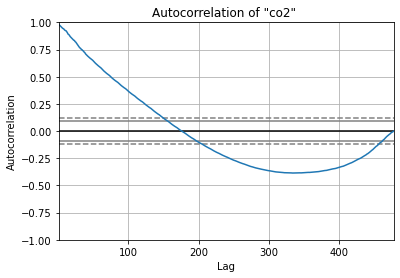

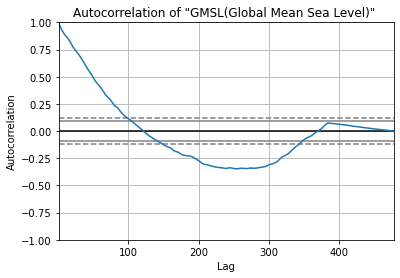

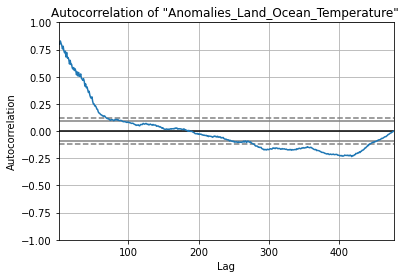

In [18]:
for c in climate_change.columns[1:]:
    pd.plotting.autocorrelation_plot(climate_change[c])
    plt.title(f'Autocorrelation of "{c}" ')
    plt.show()

How correlated are the values of the measurements this month is to ones of a year ago? To reply to this question i have to look to the lag 12.

It can been notice that for the variables relative humidity, co2, GMSL and anomalies temperature there is a positive autocorrelation. That means that an increase seen in one time series leads to a proportionate increase in the other time series. So the values are highly correlated.

Always taking into account a year as a time period (lag 12 - lag 24), also the total rain fall and the surface temperature are positevly correlated. All the values inside the shaded area aren't statistically significant.

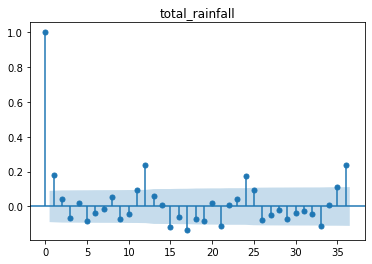

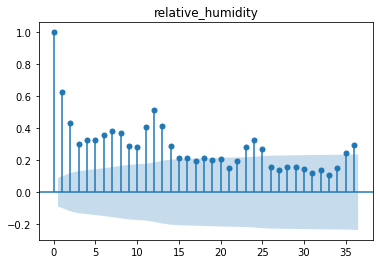

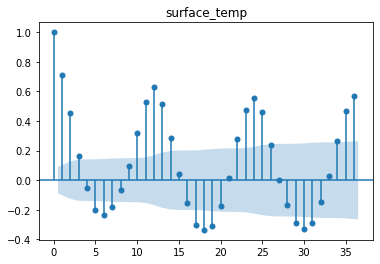

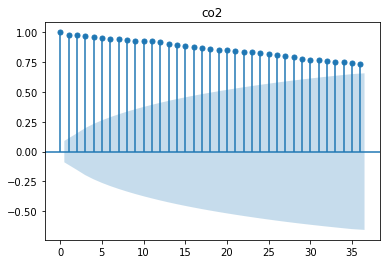

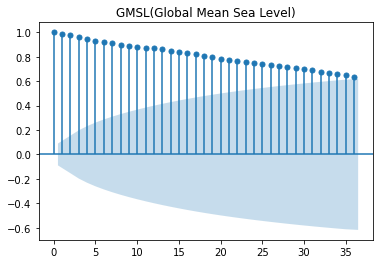

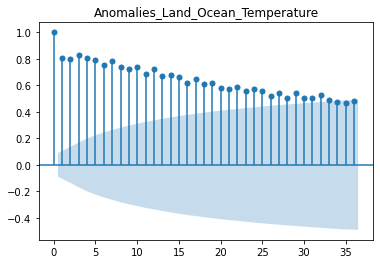

In [43]:
for c in climate_change.columns[1:]:
    plot_acf(climate_change[c], lags=36)
    plt.title(f'{c}')
    plt.show()

**Lag scatter plot**

- If the points cluster along a diagonal line from the bottom-left to the top-right of the plot, it suggests a *positive correlation* relationship;

- If the points cluster along a diagonal line from the top-left to the bottom-right, it suggests a *negative correlation relationship*.

- More points tighter in to the diagonal line suggests a stronger relationship and more spread from the line suggests a weaker relationship.

- A ball in the middle or a spread across the plot suggests a weak or no relationship.

For the surface temperature and the humidity there is a positive but weak correlation relationship, for the co2, GMSL there is a positive and strong correlation relationship whereas for the total rainfall and the anomalies temperature (in the last observation) seems that there is no correlation relationship.

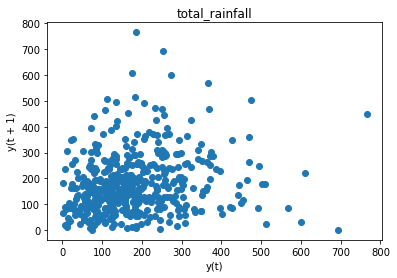

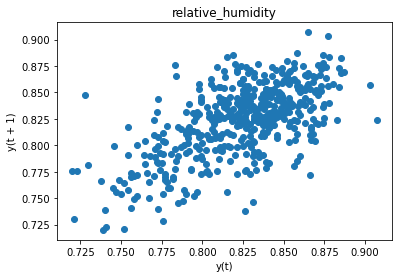

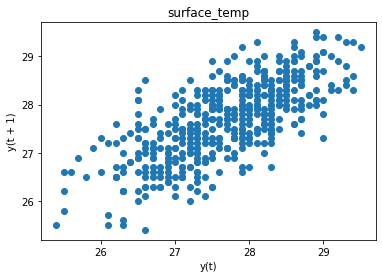

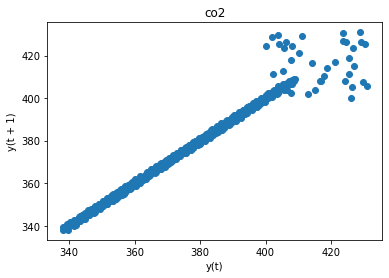

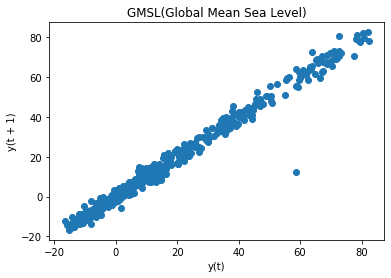

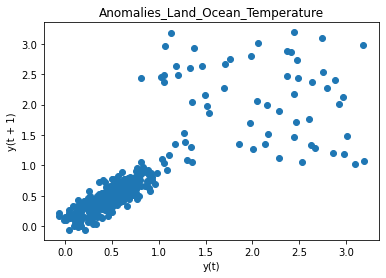

In [46]:
for c in climate_change.columns[1:]:
    pd.plotting.lag_plot(climate_change[c])
    plt.title(f'{c}')
    plt.show()

**Partial autocorrelation**

It does the same as regular autocorrelation but only the direct effect is shown, and all intermediary effects are removed. From these plots we can notice that the direct relationship between the present and the past of some measurements is a bit weaker, as we can see in the GMSL plot, and becames negative in the case of co2.

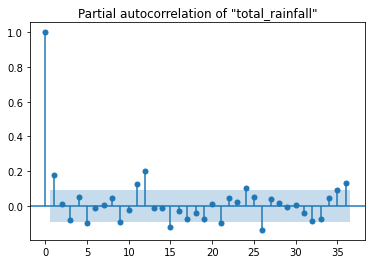

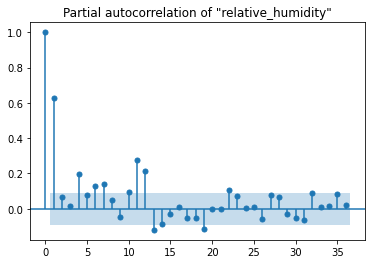

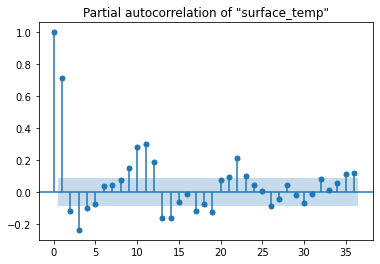

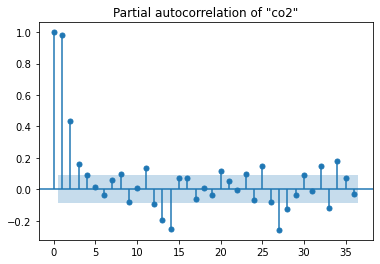

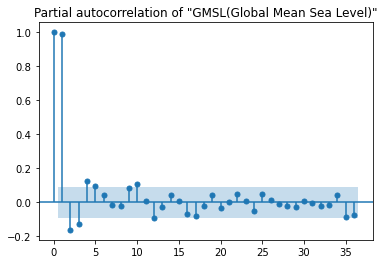

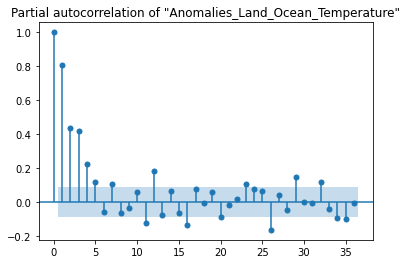

In [44]:
for c in climate_change.columns[1:]:
    plot_pacf(climate_change[c], lags=36)
    plt.title(f'Partial autocorrelation of "{c}"')
    plt.show()

## VARMA (Vector Arima for multivariate time series forecasting)

Steps:

 1) Causality investigation
 2) Test for stationary
 3) Test for autocorrelation
 4) Model 
 5) Prediction
 6) Evaluation


In [22]:
''' 1. CAUSALITY INVESTIGATION 
The Granger Causality Test is used to investigate causality of data: check if a particular variable comes before 
another in the time series.
The Null Hypothesis of the Granger Causality Test is that lagged x-values do not explain the variation in y
(so the x does not cause y).
The critical value used is 5% and if the p-value of a pair of variables is smaller than the significance level, 
then the Null Hypothesis (that the coefficients of the corresponding past values is zero, that is, the X does not 
cause Y) can be rejected.
In the output the rows are the response variable and the columns are the predictors
'''
maxlag=15
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables) #create the df for the results
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False) #perform the test
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

#climate_change.set_index('Date',inplace=True)
climate_change = pd.read_csv('climate_change.csv', index_col='Date')
grangers_causation_matrix(climate_change, variables = climate_change.columns)   

,no_of_rainy_days_x,total_rainfall_x,relative_humidity_x,surface_temp_x,co2_x,GMSL(Global Mean Sea Level)_x,Anomalies_Land_Ocean_Temperature_x
no_of_rainy_days_y,1.0000,0.0024,0.0000,0.0000,0.0001,0.0426,0.0425
total_rainfall_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.2217,0.1196
relative_humidity_y,0.0000,0.0000,1.0000,0.0000,0.0000,0.2417,0.0000
surface_temp_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.3046,0.0001
co2_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0077,0.0000
GMSL(Global Mean Sea Level)_y,0.0549,0.0088,0.0449,0.1611,0.0122,1.0000,0.7400
Anomalies_Land_Ocean_Temperature_y,0.0071,0.0753,0.0001,0.0044,0.0000,0.3452,1.0000


Let's analyze the result obtained. For most of the variables, since the p-values are < 0.05, i can reject the null hypothesis and use them for the VARMA model. 

But for some variables i can't reject the null hypothesis, in fact the p-values for:
- (GMSL_x,total_rainfall_y) - (GMSL_x,relative_humidity_y) - (GMSL_x,surface_temp_y) 

- (Anomalies_Land_Ocean_Temperature_x,total_rainfall_y)

- (co2_x,GMSL(Global Mean Sea Level)_y)

are bigger than 0.05. That means that the **GMSL doesn't cause the total rainfall, the relative humidity and the surface temperature**, as well as the **Anomalies_Land_Ocean_Temperature doesn't cause the total rainfall** and the **co2 doesn't cause the mean sea level**. 

*As it can be notice, this analysis makes sense since - for example - it's reasonable that the total rainfall causes the surface temperature, the humidity and the anomalies in the temperature; just as it would have made less sense if the co2 emissions causes the Sea Level - but for sure it causes the surface temperature.*

In the end I can state that, exept for the GMSL and the others two pairs listed before, the other variables are interchangeably causing each other. 

For now on i will not include the GMSL in the model.

In [23]:
#CLIMATE DATA WITHOUT GMSL
data_cc = climate_change.drop(['GMSL(Global Mean Sea Level)'],axis=1)

In [24]:
''' 2. STATIONARITY TEST
VectorARMA requires time series to be stationary(mean and variance does not change over time), to test it
i use the ADF Test.
'''

def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 

    if p_value <= sig:
        print(f" {name} : P-Value = {p_value} => Stationary")
    else:
        print(f" {name} : P-Value = {p_value} => Non-stationary")

for name, column in data_cc.iteritems():
    adfuller_test(column, name=column.name)

 no_of_rainy_days : P-Value = 0.0 => Stationary
 total_rainfall : P-Value = 0.0 => Stationary
 relative_humidity : P-Value = 0.233 => Non-stationary
 surface_temp : P-Value = 0.0 => Stationary
 co2 : P-Value = 0.45 => Non-stationary
 Anomalies_Land_Ocean_Temperature : P-Value = 0.895 => Non-stationary


In [25]:
# Train-test splitting
n_obs = 12 #forecast on the next 12 observation (12 months = one year)
train,test =  data_cc[0:-n_obs], data_cc[-n_obs:]

'''
Since for the relative_humidity,co2 and Anomalies_Land_Ocean_Temperature the test fails, 
i need to make the data stationary (eliminating the trend and seasonality by differencing.
Differencing reduces the length of the series by 1 and since all the time series has to be of the same length, 
i apply the diff() method to all the series.
'''
data_differenced = train.diff().dropna() #diffence the train data
for name, column in data_differenced.iteritems():
    adfuller_test(column, name=column.name)


 no_of_rainy_days : P-Value = 0.0 => Stationary
 total_rainfall : P-Value = 0.0 => Stationary
 relative_humidity : P-Value = 0.0 => Stationary
 surface_temp : P-Value = 0.0 => Stationary
 co2 : P-Value = 0.0 => Stationary
 Anomalies_Land_Ocean_Temperature : P-Value = 0.0 => Stationary


In [27]:
# To find the optimal values of p I will perform the model.select_order() method that highlight
# with a * the lowest AIC value.
model = VAR(data_differenced)
x = model.select_order(maxlags=16)
x.summary()

C:\Users\Stefania\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,3.861,3.916,47.51,3.883
1,2.606,2.990,13.54,2.757
2,2.023,2.736,7.559,2.304
3,1.550,2.593,4.714,1.961
4,1.210,2.582*,3.354,1.750
5,1.060,2.761,2.889,1.730
6,0.8542,2.885,2.355,1.655*
7,0.7890,3.149,2.209,1.719
8,0.7711,3.460,2.173,1.831
9,0.6916,3.710,2.012,1.881


As the value of the P increases model becomes more complex and the AIC penalizes the complex model.

As can be seen from the result, the AIC begins to drop as i fit the more complex model (around 11) but, after a certain amount of time AIC begins to increase again (from 13). It’s because AIC is punishing these models for being too complex.

The VAR(p=12) returns the lowest score and after that again AIC starts increasing, hence i will build the VAR model of order 12. 

In [28]:
# train the VAR model of selected order (p=12)
p=12
model_fitted = model.fit(16) #cambia con p
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 12, Dec, 2021
Time:                     15:39:36
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    5.11180
Nobs:                     449.000    HQIC:                   1.88664
Log likelihood:          -3193.08    FPE:                   0.843430
AIC:                    -0.211777    Det(Omega_mle):        0.260838
--------------------------------------------------------------------
Results for equation no_of_rainy_days
                                          coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------------
const                                        0.452025         0.392983            1.150           0.250
L1.no_of_rainy_days                         -0.756740        

Durbin-Watson Statistic 

Test to check the autocorrelation. The result of this test will be a value in range [0.0,4.0]. A value of 2.0 means that there is no auto-correlation detected in the sample. Values from 0 to less than 2 indicate positive auto-correlation and values from 2 to 4 indicate negative auto-correlation. A rule of thumb is that test statistic values in the range of 1.5 to 2.5 are relatively normal. Any value outside this range could be a cause for concern.

In [29]:
out = durbin_watson(model_fitted.resid)
for col,val in zip (data_differenced.columns,out):
    print((col),':',round(val,2))

no_of_rainy_days : 2.0
total_rainfall : 1.98
relative_humidity : 1.99
surface_temp : 1.98
co2 : 2.09
Anomalies_Land_Ocean_Temperature : 2.0


From the results obtained I can state that there is no autocorrelation, since all values are in the range [1.5,2] hence i can procede with the forecasting

PREDICTION

In order to forecast, the VAR model expects up to the lag order number of observations from the past data since the terms in the VAR model are essentially the lags of the various time series in the dataset.

In [30]:
lag = model_fitted.k_ar #12

# input data for forecasting
lagged_Values = data_differenced.values[-lag:] # specify the 'initial value' for the forecast

# Forecast
pred = model_fitted.forecast(y= lagged_Values,steps= n_obs) 
df_pred = (pd.DataFrame(pred, index=test.index, columns=test.columns + '_pred'))
df_pred

,no_of_rainy_days_pred,total_rainfall_pred,relative_humidity_pred,surface_temp_pred,co2_pred,Anomalies_Land_Ocean_Temperature_pred
Date,,,,,,
2020-11,-3.595273,-269.933637,0.011644,1.159314,-10.141284,-2.783438
2020-12,-9.039593,275.041439,-0.032020,0.906419,20.019159,2.058130
2021-01,11.808343,164.950346,0.015114,-1.202142,-16.707648,1.366151
2021-02,1.868471,-284.211038,-0.014198,-0.873355,-2.136618,-2.483611
2021-03,-8.177425,68.514480,-0.001365,0.949304,-1.990439,0.694515
2021-04,-2.005792,215.699188,0.065556,-1.266749,-28.871831,1.202293
2021-05,-1.569864,-208.895711,-0.067383,0.493230,71.838621,-0.386469
2021-06,17.502288,186.651076,0.025060,-0.300774,-27.854381,-1.819838
2021-07,-0.669417,6.651947,0.073411,-0.682976,-23.499121,-0.589111


INVERT THE TRANSFORMATION

Notice that the forecasted value is a first-order difference. To get it similar to original data i have to 'roll back' each difference by taking the most recent values of the original series’ training data and adding it to a cumulative sum of forecasted values (first determine the cumulative sum at index and then add it to the base number)


In [31]:
def invert_transformation(train, pred):
    forecast = pred.copy()
    columns = train.columns
    for col in columns[1:]:
        forecast[str(col)+'_pred'] = train[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
    return forecast

result = invert_transformation(train, df_pred)

### Plot the result

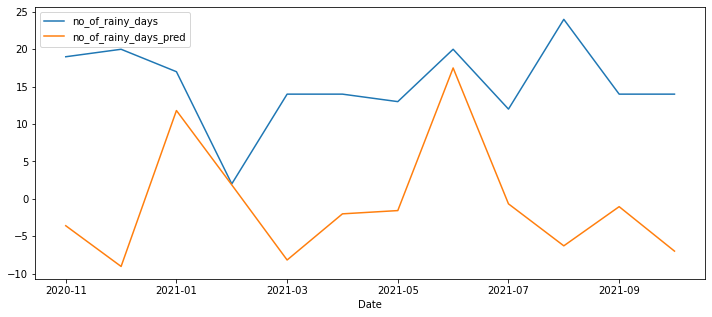

In [32]:
test_or = data_cc[-n_obs:]
test_or['no_of_rainy_days'].plot(figsize=(12,5),legend=True);
result['no_of_rainy_days_pred'].plot(legend=True);

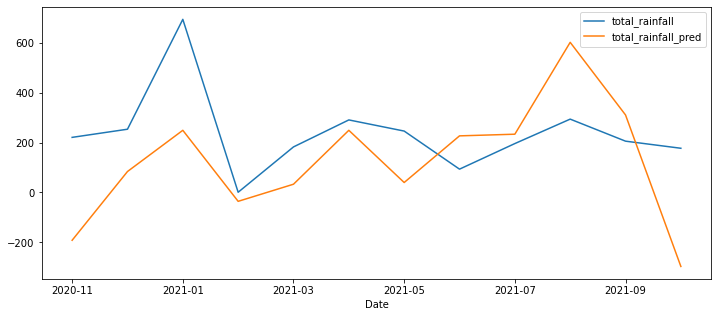

In [33]:
test_or['total_rainfall'].plot(figsize=(12,5),legend=True);
result['total_rainfall_pred'].plot(legend=True);

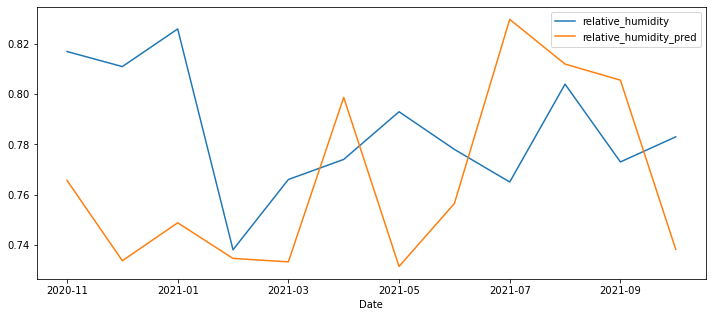

In [34]:
test_or['relative_humidity'].plot(figsize=(12,5),legend=True);
result['relative_humidity_pred'].plot(legend=True);

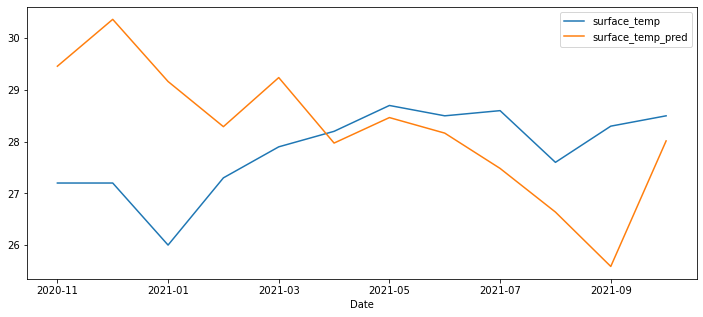

In [35]:
test_or['surface_temp'].plot(figsize=(12,5),legend=True);
result['surface_temp_pred'].plot(legend=True);

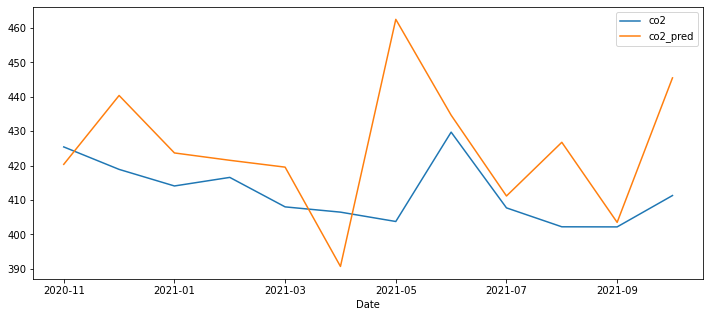

In [36]:
test_or['co2'].plot(figsize=(12,5),legend=True);
result['co2_pred'].plot(legend=True);

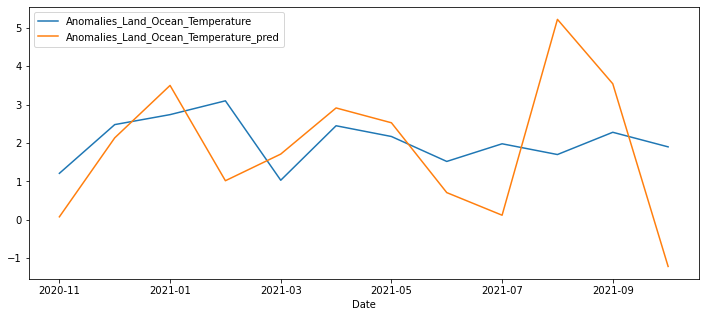

In [37]:
test_or['Anomalies_Land_Ocean_Temperature'].plot(figsize=(12,5),legend=True);
result['Anomalies_Land_Ocean_Temperature_pred'].plot(legend=True);

### Evaluate the forecast

In [38]:
for p,t in zip(result.columns,test.columns):
    combine = pd.concat([result[p], test[t]], axis=1)
    print(f'{p}')
    print(f'RMSE : ', round(sqrt(mean_squared_error(combine[t].values, combine[p].values)),3))
    print(f'R² :', metrics.r2_score(combine[t].values,combine[p].values))
    print('--------------------')
    print()

no_of_rainy_days_pred
RMSE :  18.466
R² : -11.169285665554826
--------------------

total_rainfall_pred
RMSE :  259.989
R² : -1.7037123553288827
--------------------

relative_humidity_pred
RMSE :  0.048
R² : -2.93583906227304
--------------------

surface_temp_pred
RMSE :  1.777
R² : -4.348214032705561
--------------------

co2_pred
RMSE :  22.826
R² : -6.00217748331377
--------------------

Anomalies_Land_Ocean_Temperature_pred
RMSE :  1.707
R² : -7.392444750967501
--------------------



## GENERATE FUTURE FORECAST